In [2]:
from vumt.data import DataSource, FeatureRequest
import os
from vumt import rsam
from obspy import UTCDateTime, Trace
import xarray as xr
import pandas as pd

#Test: for developing autoencoder and encoding space for classification using RF
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt

#for running the autoencoder and fussy clustering from VUMPT (pytorch develoment): 
from vumt import autoencoder


2024-06-07 17:15:35.750152: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 17:15:40.279248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/sapthala/miniforge/envs/vumt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###Just testing data but not using WIZ data with the autoencoder 

In [2]:
#To access features via API (RC1 container is running): 
#at the moment only WIZ data available via RC1
#example of accessing rsam data via APIendpoint
#diffrent available features: 
# features = ('dsar', 'rsam', 'ssam', 'rsam_energy_prop',
#                 'central_freq', 'bandwidth', 'predom_freq',
#                 'sonogram', 'filterbank')
#example a data request:
feature="rsam"
starttime="2019-12-01T00:00:00"
endtime="2019-12-31T00:00:00"
volcano="Whakaari"
site="WIZ"
url = f"http://kaizen.gns.cri.nz:9157/feature?name={feature}&starttime={starttime}&endtime={endtime}&volcano={volcano}&site={site}"
rsamDF = pd.read_csv(url, parse_dates=True, index_col=0)

In [9]:
#get few feature data
starttime="2019-12-01T00:00:00"
endtime="2019-12-31T00:00:00"
volcano="Whakaari"
site="WIZ"
#rsam
rsam="rsam"
url1 = f"http://kaizen.gns.cri.nz:9157/feature?name={rsam}&starttime={starttime}&endtime={endtime}&volcano={volcano}&site={site}"
rsamDF = pd.read_csv(url1, parse_dates=True, index_col=0)
# #ssam
# ssam="ssam"
# url2 = f"http://kaizen.gns.cri.nz:9158/feature?name={ssam}&starttime={starttime}&endtime={endtime}&volcano={volcano}&site={site}"
# ssamDF = pd.read_csv(url2, parse_dates=True, index_col=0)
#predom_freq
predom_freq="predom_freq"
url3 = f"http://kaizen.gns.cri.nz:9157/feature?name={predom_freq}&starttime={starttime}&endtime={endtime}&volcano={volcano}&site={site}"
predom_freqDF = pd.read_csv(url3, parse_dates=True, index_col=0)

In [56]:
#Getting data from Erebus as Erubus API is currenlty running with the autoencoder and the clusturing algorithm developed by ......
#erub_rsam = "http://kaizen.gns.cri.nz:32771/feature?name={rsam}&starttime={2022-12-13T00:00:00}&endtime={2023-04-13T00:00:00}&volcano={Erebus}&site={HOO}&channel={BHZ}"
#autoencoder input features: 
features = ['rsam',
            'dsar',
            'central_freq',
            'predom_freq',
            'bandwidth',
            'rsam_energy_prop',
            'sonogram']



# read Erebus features
#get few feature data from Erebus
starttime="2022-12-13T00:00:00"
endtime="2023-04-13T00:00:00"
volcano="Erebus"
site="HOO"
channel="BHZ"
fname="rsam"
url1 = f"http://kaizen.gns.cri.nz:32771/feature?name={fname}&starttime={starttime}&endtime={endtime}&volcano={volcano}&site={site}&channel={channel}"
rsamDF = pd.read_csv(url1, parse_dates=True, index_col=0)

fname="predom_freq"
url1 = f"http://kaizen.gns.cri.nz:32771/feature?name={fname}&starttime={starttime}&endtime={endtime}&volcano={volcano}&site={site}&channel={channel}"
pfreqDF = pd.read_csv(url1, parse_dates=True, index_col=0)

fname="dsar"
url1 = f"http://kaizen.gns.cri.nz:32771/feature?name={fname}&starttime={starttime}&endtime={endtime}&volcano={volcano}&site={site}&channel={channel}"
dsarDF = pd.read_csv(url1, parse_dates=True, index_col=0)

fname="central_freq"
url1 = f"http://kaizen.gns.cri.nz:32771/feature?name={fname}&starttime={starttime}&endtime={endtime}&volcano={volcano}&site={site}&channel={channel}"
cfreqDF = pd.read_csv(url1, parse_dates=True, index_col=0)

fname="bandwidth"
url1 = f"http://kaizen.gns.cri.nz:32771/feature?name={fname}&starttime={starttime}&endtime={endtime}&volcano={volcano}&site={site}&channel={channel}"
bandwidthDF = pd.read_csv(url1, parse_dates=True, index_col=0)

fname="rsam_energy_prop"
url1 = f"http://kaizen.gns.cri.nz:32771/feature?name={fname}&starttime={starttime}&endtime={endtime}&volcano={volcano}&site={site}&channel={channel}"
rsamenergypDF = pd.read_csv(url1, parse_dates=True, index_col=0)


In [57]:
# #dataframe cleaning and merging 
# rsamDF.index = pd.to_datetime(rsamDF.index)
# rsamDF.columns = ['rsam']
# predom_freqDF.index = pd.to_datetime(predom_freqDF.index)
# predom_freqDF.columns = ['predom_freq']
# rsam_prefreq_df = pd.merge(rsamDF, predom_freqDF, left_index=True, right_index=True)
#change index_name and reset 
featureDF = pd.concat([rsamDF, pfreqDF, dsarDF, cfreqDF, bandwidthDF, rsamenergypDF], axis=1)
featureDF.columns = ['rsam','dsar','central_freq','predom_freq','bandwidth','rsam_energy_prop']
featureDF.index.name = 'datetime'
featureDF.reset_index(inplace=True)

#for now we can drop the NANs, maybe later use interpolation?
featureDF.dropna(axis=0, inplace=True)

#rename data frame for MSDA:
df = featureDF

#process data
# Ensure the data is sorted by datetime (if needed)
df = df.sort_values(by='datetime')

# Drop the 'datetime' column for the autoencoder input
df = df.drop(columns=['datetime'])

# Step 3: Convert the dataframe to a numpy array
time_series_data = df.values

# Print the shape to ensure it loaded correctly
print(time_series_data.shape)




(16192, 6)


In [ ]:
#from vumt testing 
def setup(tmp_path_factory):
    features1D = ['rsam',
                  'dsar',
                  'central_freq',
                  'predom_freq',
                  'bandwidth',
                  'rsam_energy_prop']
    features2D = [('sonogram', 'sonofrequency'),
                  ('ssam', 'frequency'),
                  ('filterbank', 'fbfrequency')]

    savedir = tmp_path_factory.mktemp('vumt_test_tmp', numbered=True)
    widir = os.path.join(savedir,
                         'features',
                         'Whakaari',
                         'WIZ',
                         'HHZ')
    doomdir = os.path.join(savedir,
                           'features',
                           'Mt_Doom',
                           'MDR',
                           'HHZ')
    ruadir = os.path.join(savedir,
                         'features',
                         'Ruapehu',
                         'MAVZ',
                         'EHZ')
    for _dir in [widir, doomdir, ruadir]:
        os.makedirs(_dir)
   # Generate some fake data
    for _f in features1D:
        feat = generate_test_data(tstart=tstart,
                                    feature_name=_f,
                                    ndays=ndays)
        for _dir in [widir, doomdir, ruadir]:
            xarray2hdf5(feat, _dir)
    for _n, _f in features2D:
        feat = generate_test_data(tstart=tstart,
                                  feature_name=_n,
                                  ndays=ndays,
                                  nfreqs=8,
                                  freq_name=_f,
                                  dim=2)
        for _dir in [widir, doomdir, ruadir]:
            xarray2hdf5(feat, _dir)
    cfg = configparser.ConfigParser()
    cfg['DEFAULT'] = {'outdir': os.path.join(savedir, 'features')}
    fn_cfg = os.path.join(savedir, 'tmp.cfg')
    with open(fn_cfg, 'w') as configfile:
        cfg.write(configfile)
    return savedir


def setup_ac(setup):
    savedir = setup
    fq = FeatureRequest(rootdir=os.path.join(savedir, 'features'),
                        volcano='Whakaari',
                        site='WIZ',
                        channel='HHZ',
                        starttime=tstart,
                        endtime=tstart + timedelta(days=ndays))
    return savedir, fq

In [4]:
#vumt way:
st="2022-12-13T00:00:00"
et="2023-04-13T00:00:00"
volcano="Erebus"
site="HOO"
channel="BHZ"
fname="rsam"
fq = FeatureRequest(rootdir=FEATUREDIR, volcano=volcano, site=site, channel=channel, starttime=st, endtime=et)
autoE = autoencoder.AutoEncoder.fit_transform()




TypeError: fit_transform() missing 2 required positional arguments: 'self' and 'fq'

In [68]:
#Tensorflow way
# Define the autoencoder ( we need to replace this with Yanniks model)
input_dim = time_series_data.shape[1]  # Number of features (rsam and predom_freq)
encoding_dim = 4 # Dimension of the encoded representation

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

Epoch 1/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17.9008
Epoch 2/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 20.2887
Epoch 3/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.6986
Epoch 4/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.4718
Epoch 5/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.1614
Epoch 6/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.2959
Epoch 7/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.6803
Epoch 8/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 18.3104
Epoch 9/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 16.9869
Epoch 10/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 16.5174
Epoch 11/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.8877
Epoch 12/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.0687
Epoch 13/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 16.3263
Epoch 14/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20.3210
Epoch 15/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s

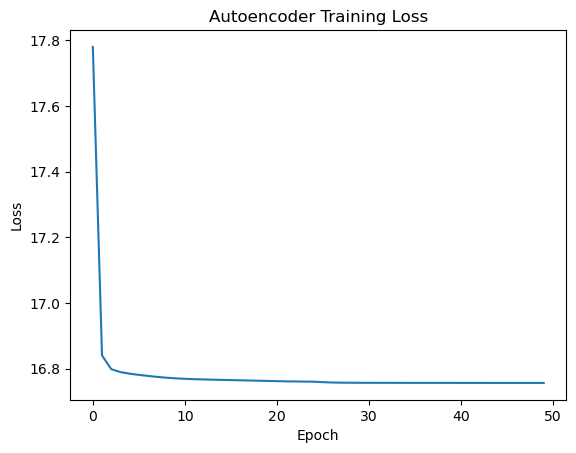

In [69]:
# Train the autoencoder
history = autoencoder.fit(time_series_data, time_series_data, epochs=50, batch_size=32, shuffle=True)



# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



In [70]:
# Encode the time series data
encoded_data = encoder.predict(time_series_data)

# Example target labels for classification
# Assuming binary classification with labels 0 and 1 ( in our case it's not binery and could be more.....labels depending on the # of clusturs?)
labels = np.random.randint(4, size=time_series_data.shape[0]) 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(encoded_data, labels, test_size=0.2, random_state=42)

# Train the RandomForest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
history2 = classifier.fit(X_train, y_train)


506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step


In [71]:
# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')



Accuracy: 0.25439950602037664


In [72]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(classifier)


# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test)
#shap.force_plot(explainer.expected_value[1], shap_values[1], X_test[0])

Old stuff..........
MSDA analysis - implementation 
You need to have MSDA pakage installed from git repo (https://pypi.org/project/msda) in your VUMT vitual environment before running MSDA commands. MSDA is an open source low-code Multi-Sensor Data Analysis library in Python. It has: 

Unsupervised time-series anomaly detector workflow
** Deep Convolutional Neural Network **

inspiration from this IEEE paper - https://ieeexplore.ieee.org/document/8581424

** LSTM Autoencoder **

inspiration from here - https://arxiv.org/pdf/1809.10717.pdf

In [12]:

import numpy as np
import operator, statistics
from statistics import mean
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from msda.msda import *
from msda.anamoly import *
%matplotlib inline

In [28]:
anamoly_data, anamoly_df = Anamoly.read_data(data=df, column_index_to_drop=0, timestamp_column_index=0)

In [29]:
#Data Preprocessing with user-input time window size
X,Y,timesteps,X_data = Anamoly.data_pre_processing(df=anamoly_df, LOOKBACK_SIZE=10)